# １、目標：アメリカの株式市場からポートフォリオを組み、3ヶ月の短期投資をシミュレーションし、その実際の収益を平均分散モデルとブラックリッターマンモデル、の二つモデルで比較して、評価する。シミュレーション期間を2012年10月1日から2019年9月12日までにします。評価期間は2020年1月10日までにします。銘柄を20にします。
## （１）外部の情報としては、まず無リスク金利とマーケットプライスを知る必要がある。無リスク金利として、13 Week Treasury Bill (^IRX)を使って測り、マーケットプライスは、S&P 500指数を使います。

In [1]:
#13 Week Treasury Billの情報をダウンロード
import pandas_datareader as pdr
import datetime
IRX = pdr.get_data_yahoo('^IRX', 
                          start=datetime.datetime(2019, 9, 12), 
                          end=datetime.datetime(2019, 9, 12))

In [2]:
IRX

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-11,1.913,1.913,1.913,1.913,0,1.913
2019-09-12,1.900,1.878,1.888,1.895,0,1.895


In [3]:
week_13_rate=IRX["Adj Close"][1]

In [4]:
week_13_rate

1.8949999809265137

## ゼロクーポン債の計算式  
## P=F/(1+(r/4))**(n**m)  
## F=債券の額面価値  
## m＝債券経過、1年内の期間数  
## ## P=債券の価格  
## r=債券の利回り  

## （２）ゼロクーポン債だから、国債の利回り＝3ヶ月のスポットレートになる。3ヶ月の投資だから、この値を無リスク金利にする

In [5]:
risk_free=week_13_rate/100
print(risk_free)

0.018949999809265136


## (３)選択した銘柄だダウンロード

In [6]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
from scipy import stats
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# 統計モデル
import statsmodels.api as sm



AAPLE = pdr.get_data_yahoo('AAPL', start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))

GOOGLE = pdr.get_data_yahoo('GOOGL', start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))

McDonalds = pdr.get_data_yahoo('MCD',start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))

GM = pdr.get_data_yahoo('GM', start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))



XOM = pdr.get_data_yahoo('XOM', start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))
BRK = pdr.get_data_yahoo('BRK-A', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))
MSFT = pdr.get_data_yahoo('MSFT', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))
WFC = pdr.get_data_yahoo('WFC', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))


AMZN = pdr.get_data_yahoo('AMZN', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))
FB = pdr.get_data_yahoo('FB', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))
JPM = pdr.get_data_yahoo('JPM', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))
VISA = pdr.get_data_yahoo('V', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))


WMT = pdr.get_data_yahoo('WMT', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))
MA = pdr.get_data_yahoo('MA', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))
PG = pdr.get_data_yahoo('PG', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))
BAC= pdr.get_data_yahoo('BAC', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))


ATT = pdr.get_data_yahoo('T',start=datetime.datetime(2012, 10, 1),
                          end=datetime.datetime(2019, 9, 12))

Intel = pdr.get_data_yahoo('INTC', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))
UnitedHealth_Group = pdr.get_data_yahoo('UNH', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))
The_Walt_Disney = pdr.get_data_yahoo('DIS', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))


In [7]:
data=pd.concat([AAPLE[["Close"]],GOOGLE[["Close"]],McDonalds[["Close"]],GM[["Close"]],
               XOM[["Close"]],BRK[["Close"]],MSFT[["Close"]],WFC[["Close"]],
                AMZN[["Close"]],FB[["Close"]],JPM[["Close"]],VISA[["Close"]],
                WMT[["Close"]],MA[["Close"]],PG[["Close"]],BAC[["Close"]],
                ATT[["Close"]],Intel[["Close"]],UnitedHealth_Group[["Close"]],The_Walt_Disney[["Close"]]],axis=1)
data.columns=["APPLE","GOOGLE","McDonalds","GM","XOM","BRK","MSFT","WFC","AMZN","FB","JPM","VISA",
             "WMT","MA","PG","BAC","ATT","Intel","UnitedHealth_Group","The_Walt_Disney"]

## （４）時系列推移と収益率をプロット

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


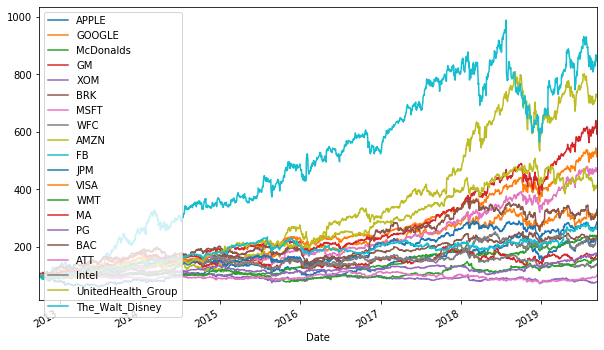

In [8]:
(data / data.ix[0] * 100).plot(figsize=(10, 6))

In [9]:
log_returns = np.log(data / data.shift(1))
log_returns.head()

,APPLE,GOOGLE,McDonalds,GM,XOM,BRK,MSFT,WFC,AMZN,FB,JPM,VISA,WMT,MA,PG,BAC,ATT,Intel,UnitedHealth_Group,The_Walt_Disney
Date,,,,,,,,,,,,,,,,,,,,
2012-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-02,0.002908,-0.006308,-0.011590,0.025231,-0.000872,0.001705,0.005748,0.003452,-0.005611,0.012653,-0.001221,-0.005353,-0.004060,0.001662,-0.009549,-0.003354,0.001588,0.003509,0.006004,-0.008292
2012-10-03,0.015217,0.007252,-0.006399,0.029542,-0.000218,0.006270,0.006720,0.017649,0.021007,-0.019955,-0.001467,0.018360,0.006083,0.034596,0.005509,0.019956,0.009476,-0.012778,0.001056,0.015945
2012-10-04,-0.006949,0.007252,0.007498,0.010604,0.005655,0.009029,0.005677,0.014844,0.017623,0.005482,0.023223,0.008268,0.006984,0.002361,0.003031,0.032400,0.004444,-0.003554,0.019334,0.003045
2012-10-05,-0.021541,-0.000521,-0.000330,0.006067,0.003572,0.002023,-0.006012,-0.003621,-0.007553,-0.048540,-0.002634,0.004215,0.005472,0.000821,0.003597,-0.009610,-0.012599,0.009302,-0.014596,0.006439


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c18beb610>,
      dtype=object)

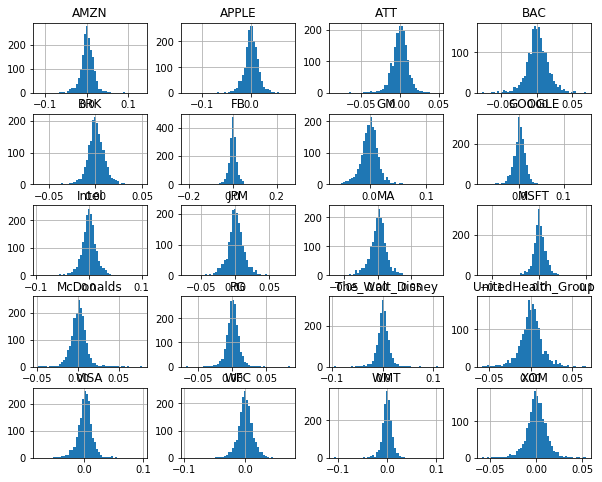

In [10]:
log_returns.hist(bins=50, figsize=(10, 8))

# ２、平均分散モデル
## （１）モデル最適化

In [124]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data,frequency=252)

#最小分散ポートフォリオ
EF_min = EfficientFrontier(mu, S)
#最小分散ポートフォリオを計算する
EF_min.min_volatility()
#ポートフォリオの年リターン、ボラティリティ、シャープ・レシオを求める
EF_min.portfolio_performance(verbose=True)

Expected annual return: 9.9%
Annual volatility: 11.1%
Sharpe Ratio: 0.72


(0.09947133480839099, 0.1110362140811254, 0.7157244640052978)

In [40]:
#CAPM理論に基づき、平均分散モデルを最適化
#無リスク金利を入れる
EF = EfficientFrontier(mu, S)
weights = EF.max_sharpe(risk_free_rate=risk_free)
#ポートフォリオの年リターン、ボラティリティ、シャープ・レシオを求める
EF.portfolio_performance(verbose=True)

Expected annual return: 26.4%
Annual volatility: 16.6%
Sharpe Ratio: 1.47


(0.2638638841740126, 0.16593786660632473, 1.4696096144984288)

In [41]:
#各ウェイトをプリントする
EF.clean_weights()

{'APPLE': 0.0,
 'GOOGLE': 0.0,
 'McDonalds': 0.11583,
 'GM': 0.0,
 'XOM': 0.0,
 'BRK': 0.0,
 'MSFT': 0.0655,
 'WFC': 0.0,
 'AMZN': 0.0982,
 'FB': 0.15167,
 'JPM': 0.0,
 'VISA': 0.11418,
 'WMT': 0.0,
 'MA': 0.20755,
 'PG': 0.0,
 'BAC': 0.0,
 'ATT': 0.0,
 'Intel': 0.0,
 'UnitedHealth_Group': 0.24707,
 'The_Walt_Disney': 0.0}

## （２）シミュレーションのために、各銘柄の2019年9月13日から2020年1月10日までのデータを取る

In [17]:
data2=pd.concat([AAPLE[["Close"]],GOOGLE[["Close"]],McDonalds[["Close"]],GM[["Close"]],
               XOM[["Close"]],BRK[["Close"]],MSFT[["Close"]],WFC[["Close"]],
                AMZN[["Close"]],FB[["Close"]],JPM[["Close"]],VISA[["Close"]],
                WMT[["Close"]],MA[["Close"]],PG[["Close"]],BAC[["Close"]],
                ATT[["Close"]],Intel[["Close"]],UnitedHealth_Group[["Close"]],The_Walt_Disney[["Close"]]],axis=1)
data2.columns=["APPLE","GOOGLE","McDonalds","GM","XOM","BRK","MSFT","WFC","AMZN","FB","JPM","VISA",
             "WMT","MA","PG","BAC","ATT","Intel","UnitedHealth_Group","The_Walt_Disney"]

In [18]:
AAPLE = pdr.get_data_yahoo('AAPL', start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))

GOOGLE = pdr.get_data_yahoo('GOOGL', start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))

McDonalds = pdr.get_data_yahoo('MCD',start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))

GM = pdr.get_data_yahoo('GM', start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))



XOM = pdr.get_data_yahoo('XOM', start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))
BRK = pdr.get_data_yahoo('BRK-A', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))
MSFT = pdr.get_data_yahoo('MSFT', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))
WFC = pdr.get_data_yahoo('WFC', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))


AMZN = pdr.get_data_yahoo('AMZN', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))
FB = pdr.get_data_yahoo('FB', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))
JPM = pdr.get_data_yahoo('JPM', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))
VISA = pdr.get_data_yahoo('V', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))


WMT = pdr.get_data_yahoo('WMT', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))
MA = pdr.get_data_yahoo('MA', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))
PG = pdr.get_data_yahoo('PG', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))
BAC= pdr.get_data_yahoo('BAC', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))

ATT = pdr.get_data_yahoo('T',start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))

Intel = pdr.get_data_yahoo('INTC', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))
UnitedHealth_Group = pdr.get_data_yahoo('UNH', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))
The_Walt_Disney = pdr.get_data_yahoo('DIS', 
                          start=datetime.datetime(2019, 9, 13), 
                          end=datetime.datetime(2020, 1, 10))



## （３）2019年9月13日から2020年1月10日まで運用したらポートフォリオの平均収益は  
## R=1r1+w2r2+...+wn*rn  
## ri=個々の銘柄のリターン  
## wi=個々の銘柄のウェイト  
## R=ポートフォリオの平均収益  

In [42]:
Mean_variance_return=np.sum(np.array(EF.weights)*np.array(expected_returns.mean_historical_return(data2, frequency=252)))

In [43]:
Mean_variance_return

0.40927120128735733

平均分散モデルポートフォリオのリターンは40.93パーセントになりました

## （４）平均分散モデルポートフォリオのボラティリティ

In [44]:
from pypfopt import objective_functions
objective_functions.volatility(EF.weights, risk_models.sample_cov(data2))

0.015255024700196337

# ３、ブラック–リッターマンモデル

## （１）シミュレーション期間、2019年9月13日から2020年1月10日までの各銘柄のリターンを算出

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


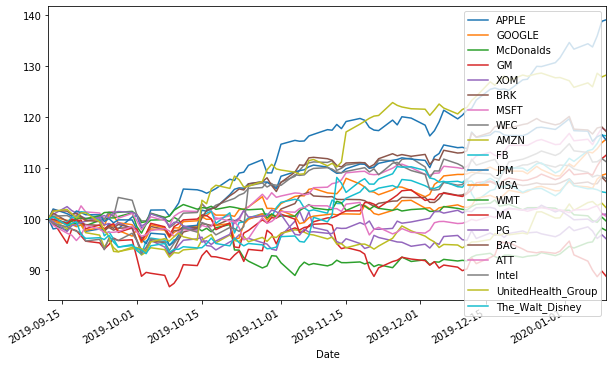

In [22]:
(data2 / data2.ix[0] * 100).plot(figsize=(10, 6))

In [23]:
expected_returns.mean_historical_return(data2, frequency=252)

APPLE                 1.020638
GOOGLE                0.455194
McDonalds            -0.056193
GM                   -0.332278
XOM                  -0.103595
BRK                   0.218532
MSFT                  0.496388
WFC                   0.244045
AMZN                  0.078850
FB                    0.480331
JPM                   0.448549
VISA                  0.270242
WMT                  -0.008414
MA                    0.377341
PG                    0.041660
BAC                   0.494096
ATT                   0.028781
Intel                 0.345550
UnitedHealth_Group    0.783174
The_Walt_Disney       0.174615
dtype: float64

## （３）銘柄ごとの評論家レビューの設定  
以上の図とデータを参考すると、  
例えば、ある評論家は、3ヶ月以降はアップルの株がこれから100パーセント上がり、ユナイテッドヘルス・グループ、グーグル、マイクロソフト、フェイスブック、バンク・オブ・アメリカとJPモルガンが50パーセント、上がると予測し、他の銘柄は未知だとします。そうすると、ブラックリッターマンモデルを利用し、以下のように設定する

In [24]:
from pypfopt.black_litterman import BlackLittermanModel
S = risk_models.sample_cov(data)
# viewdict = {"APPLE": 1, "McDonalds": 0,"GM": 0,"XOM": 0,"BRK": 0,"WFC": 0,\
#             "VISA": 0,"WMT": 0,"MA": 0,"PG": 0,"ATT": 0,"Intel": 0,"The_Walt_Disney": 0,
#             "UnitedHealth_Group": 0.5, "GOOGLE": \
#             0.5,"MSFT": 0.5,"FB": 0.5,"JPM": 0.5,"BAC": 0.5}

viewdict = {"APPLE": 1,
           "UnitedHealth_Group": 0.5, "GOOGLE": \
            0.5,"MSFT": 0.5,"FB": 0.5,"JPM": 0.5,"BAC": 0.5}

In [25]:
bl = BlackLittermanModel(S, absolute_views=viewdict)
rets = bl.bl_returns()

/usr/local/anaconda3/lib/python3.7/site-packages/pypfopt/black_litterman.py:173: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")


## (4)各銘柄のリターンを計算する

In [26]:
rets

APPLE                 0.604285
GOOGLE                0.418236
McDonalds             0.166692
GM                    0.328354
XOM                   0.241638
BRK                   0.266731
MSFT                  0.424671
WFC                   0.319475
AMZN                  0.439121
FB                    0.444449
JPM                   0.388216
VISA                  0.346454
WMT                   0.161930
MA                    0.383109
PG                    0.147596
BAC                   0.443831
ATT                   0.165389
Intel                 0.361056
UnitedHealth_Group    0.360723
The_Walt_Disney       0.257629
dtype: float64

## （５）市場価格としてSP500を導入する

In [27]:
SP500 = pdr.get_data_yahoo('^GSPC', 
                          start=datetime.datetime(2012, 10, 1), 
                          end=datetime.datetime(2019, 9, 12))

In [28]:
market_prices=SP500["Close"]

## （６）同じくシミュレーション期間を2012年10月1日から2019年9月12日までにします。

In [29]:
from pypfopt import black_litterman

delta = black_litterman.market_implied_risk_aversion(market_prices,risk_free_rate=risk_free)

ef = EfficientFrontier(rets, S)

bl.bl_weights(delta)
weights = bl.clean_weights()

In [31]:
bl.portfolio_performance(verbose=True)

Expected annual return: 47.4%
Annual volatility: 17.3%
Sharpe Ratio: 2.62


(0.4743597141133786, 0.1732496552572802, 2.6225721109727043)

In [32]:
weights

{'APPLE': 0.37461,
 'GOOGLE': 0.09254,
 'McDonalds': 0.0,
 'GM': 0.0,
 'XOM': 0.0,
 'BRK': 0.0,
 'MSFT': 0.08709,
 'WFC': 0.0,
 'AMZN': 0.0,
 'FB': 0.0292,
 'JPM': 0.16566,
 'VISA': 0.0,
 'WMT': 0.0,
 'MA': 0.0,
 'PG': 0.0,
 'BAC': 0.05422,
 'ATT': 0.0,
 'Intel': 0.0,
 'UnitedHealth_Group': 0.19668,
 'The_Walt_Disney': 0.0}

In [33]:
sum(weights.values())

1.0000000000000002

## （７）2019年9月13日から2020年1月10日まで運用したらポートフォリオの平均収益は  
## R=1r1+w2r2+...+wn*rn
## ri=個々の銘柄のリターン
## wi=個々の銘柄のウェイト
## R=ポートフォリオの平均収益

In [34]:
BL_return=np.sum(np.array(bl.weights)*np.array(expected_returns.mean_historical_return(data2, frequency=252)))

In [35]:
BL_return

0.7368515959140338

## （８）ポートフォリオのボラティリティ 

In [36]:
from pypfopt import objective_functions
objective_functions.volatility(bl.weights, risk_models.sample_cov(data2))

0.017013709075012845

## ブラックリッターマンモデルのリターンは、73.67パーセントになりました、

# ４、ポートフォリオの比較

## （１）ポートフォリオウェイトの比較

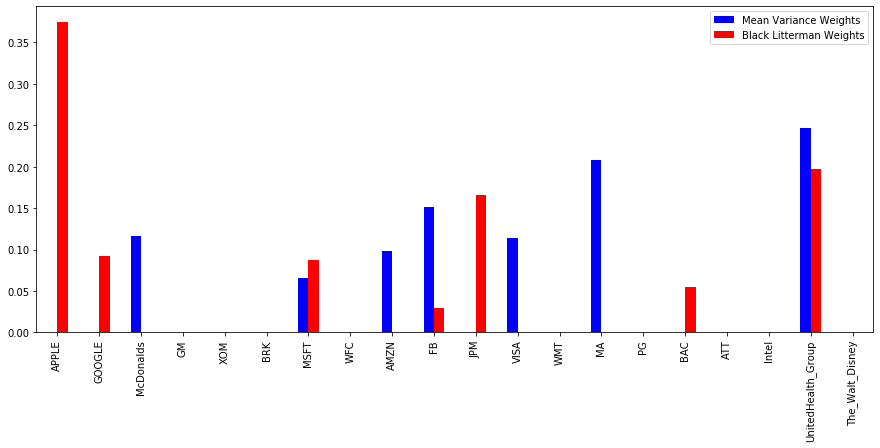

In [52]:
df = pd.DataFrame([EF.weights.reshape(20),np.array(list(bl.weights)).reshape(20)],
                  columns=["APPLE","GOOGLE","McDonalds","GM","XOM","BRK","MSFT","WFC","AMZN","FB","JPM","VISA",
             "WMT","MA","PG","BAC","ATT","Intel","UnitedHealth_Group","The_Walt_Disney"],
                  index=['Mean Variance Weights','Black Litterman Weights'])
df.T.plot(kind='bar', color='br',figsize=(15, 6))

## （２）分析
## 青がもともとの株のウェイト、赤が新しく計算された、投資家のビューを組み入れたポートフォリオウェイトを表しています。アップル、グールル、JPモルガンの株が上がるという情報が入ったことから、ブラックリッターマンモデルで、ウェイトが新しく算出されました。

## （３）シミュレーションしたポートフォリオ収益率、ボラティリティの比較

In [82]:
df2 = pd.DataFrame([[objective_functions.volatility(EF.weights, risk_models.sample_cov(data2)),\
                    objective_functions.volatility(bl.weights, risk_models.sample_cov(data2))
                    ],[Mean_variance_return,BL_return]],columns=["平均分散モデル","ブラックリッターマンモデル"],index=["ボラティリティ","収益率"])
    
df2  

,平均分散モデル,ブラックリッターマンモデル
ボラティリティ,0.015255,0.017014
収益率,0.409271,0.736852


# ５、結論
## 2019年9月13日から2020年1月10日まで運用で、平均分散モデルと、ブラックリッターマンモデルを比較して、ポートフォリオの平均収益を求めた結果、ブラックリッターマンモデルを取り入れることで、ボラティリティがわずか、0.1パーセント上がり、ブラックリッターマンモデルの収益率が平均分散モデルよりも33%あげるという結果になりました。関係研究論文を読めば、結果としては当たり前のようになりますが、他人より優れた情報を持つと信じる人は、市場平均のポートフォリオ以上に高い成績を収めることを示唆しています。ポートフォリオ運用は、アルゴリズムだけでなく、評論家の情報や市場の情報、そして何よりも企業分析をきちんと行うことが大事だと思われます。